In [1]:
import numpy as np
import numpy.linalg as LA
from scipy.linalg import null_space, schur

from lie_groups.types import MatrixLieAlgElt
from lie_groups import killing, su2, so3, sun
from lie_groups.representations import adjoint_matrices
from lie_groups.util import canonicalize, orth_complement, intersect

In [2]:
b1 = np.array([[1.0, 0.0, 0.0], [1.0, 1.0, 0.0]]).T
b2 = np.array([[1.0, 2.0, 3.0], [0.0, 1.0, 3.0]]).T
canonicalize(intersect(b1, b2))

array([[0.70710678],
       [0.70710678],
       [0.        ]])

In [3]:
def cartan_subalgebra(adjoint_rep: list[np.ndarray]) -> list[np.ndarray]:
    # stack adjoint mats along last axis so we can take linear combinations easily
    adj_matrices = np.stack(adjoint_rep, axis=-1)
    dim = adj_matrices.shape[0]
    if dim == 0:
        return []
    # start with [1, 0, ...] as element of subalgebra
    first_subalg_vec = np.array([1.0] + [0.0] * (dim - 1))
    subalg_vecs = [first_subalg_vec]
    while True:
        subalg_matrix = np.stack(subalg_vecs, axis=1)
        subalg_adjoints = adj_matrices @ subalg_matrix  # (dim, dim, len(subalg))
        stacked_adjoint_matrix = np.moveaxis(subalg_adjoints, -1, 0).reshape(len(subalg_vecs) * dim, dim)

        ns = null_space(stacked_adjoint_matrix, rcond=1e-10)
        # print("NULL SPACE")
        # print(np.round(ns, 5))
        # find a null vector outside the span of subalg_vecs
        new_ns = orth_complement(ns, subalg_matrix)
        # print("NEW NULL SPACE")
        # print(np.round(new_ns, 5))
        if new_ns.shape[1] > 0:
            subalg_vecs.append(new_ns[:, 0])
        else:
            break
    return subalg_vecs

In [4]:
def simultaneous_diag(matrices: list[np.ndarray], space: np.ndarray) -> np.ndarray:
    """Find a basis of the column span of `space` which diagonalizes all the normal matrices."""
    # due to degenerate eigenvalues, we can't just diagonalize any random matrix
    # instead, we diagonalize each matrix to get proposed subspaces
    # and we iteratively intersect these subspaces

    proposed_subspaces = [space]
    for matrix in matrices:
        eigval_triangle, eigvecs = schur(matrix, output="complex")
        eigvals = np.diag(eigval_triangle)  # normal, so these are all that matter
        # find any close-together eigenvalues and cluster those rows into a single subspace
        # brute force n^2, since complex numbers don't sort well
        index_clusters = []
        for i in range(len(eigvals)):
            eig = eigvals[i]
            for j in range(len(index_clusters)):
                representative = eigvals[index_clusters[j][0]]
                if abs(eig - representative) < 1e-10:
                    index_clusters[j].append(i)
                    break
            else:
                index_clusters.append([i])
        # pairwise intersect the subspaces
        new_subspaces = []
        for subspace1 in proposed_subspaces:
            for new_subspace_indices in index_clusters:
                subspace2 = eigvecs[:, new_subspace_indices]
                new_subspace = intersect(subspace1, subspace2)
                if new_subspace.shape[1] > 0:
                    new_subspaces.append(new_subspace)
        old_dim = sum(b.shape[1] for b in proposed_subspaces)
        new_dim = sum(b.shape[1] for b in new_subspaces)
        if old_dim != new_dim:
            raise ValueError(f"Error: total dimension changed during intersection ({old_dim} -> {new_dim})")
        proposed_subspaces = new_subspaces
    return np.concatenate(proposed_subspaces, axis=1)

In [5]:
# one interesting idea is to first take a random linear combination
# with high probabiilty this has no degeneracy unless all the matrices share
# a degeneracy

In [6]:
basis = sun.su3.basis()

In [7]:
rep_matrices = adjoint_matrices(basis)

In [8]:
cartan = cartan_subalgebra(rep_matrices)

In [9]:
rep_matrix_stack = np.stack(rep_matrices, axis=-1)

In [10]:
cartan_mats = [rep_matrix_stack @ c for c in cartan]

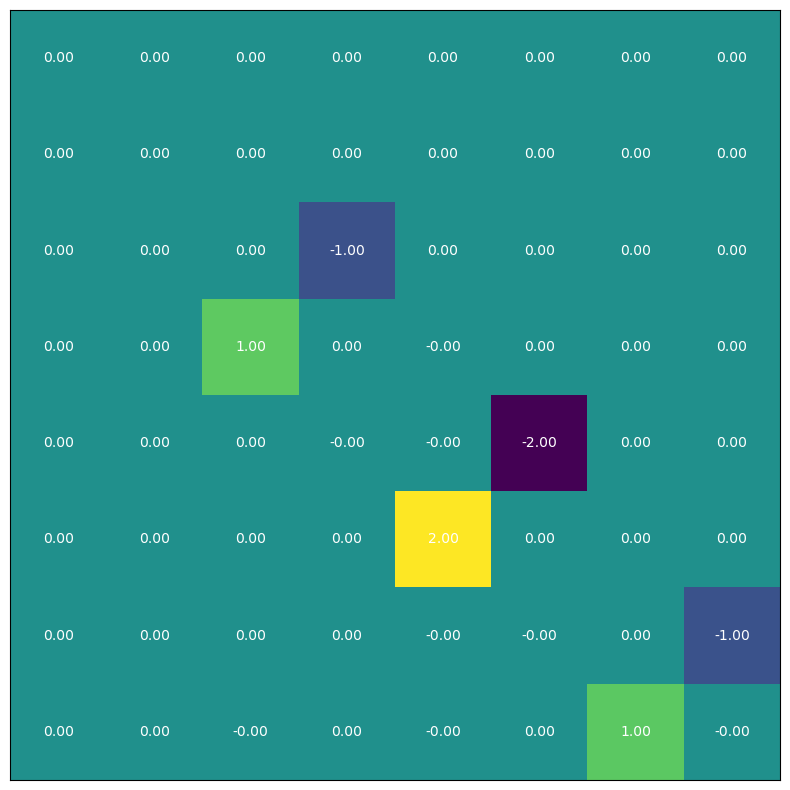

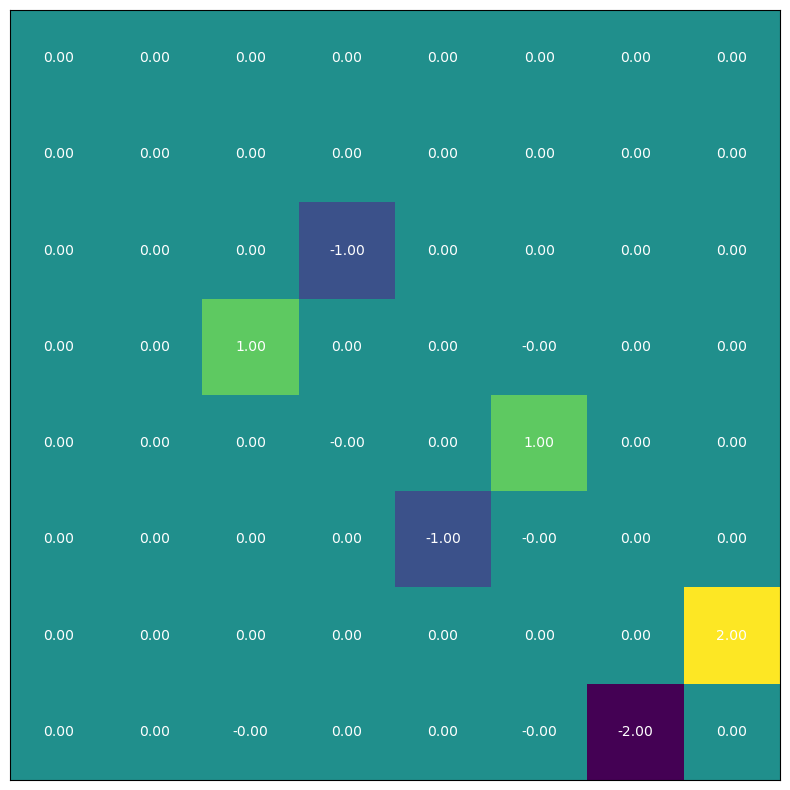

In [11]:
from lie_groups.viz import complex_heatmap, heatmap

for mat in cartan_mats:
    heatmap(mat)

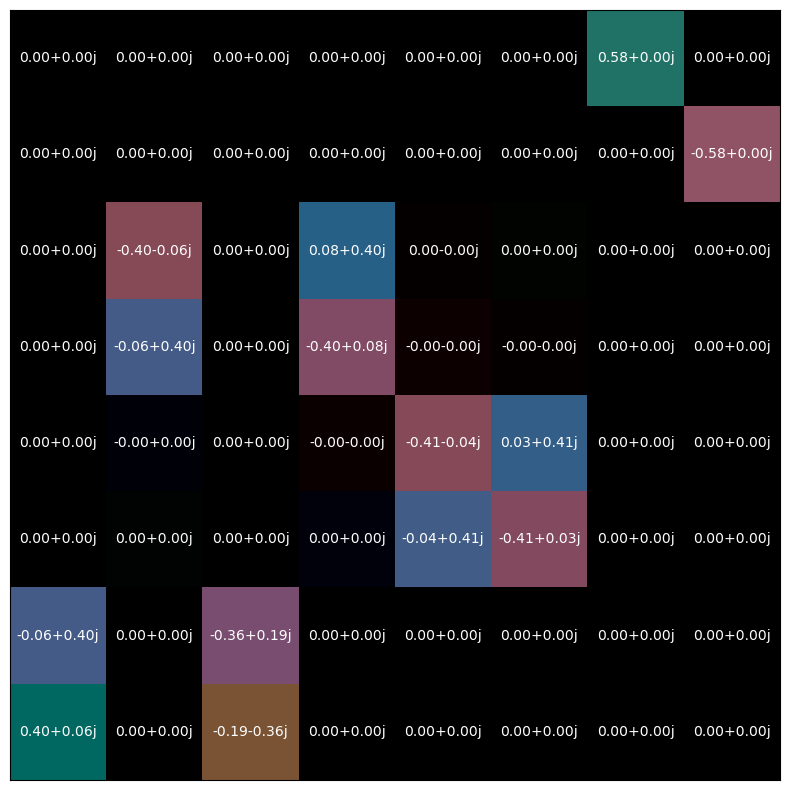

In [12]:
complex_heatmap(simultaneous_diag(cartan_mats, np.eye(8)))

In [2]:
basis = [su2.LieAlgElt(su2.S(i)) for i in range(1, 4)]
adj = adjoint_matrices(basis)
for mat in adj:
    print(np.round(mat, 4))

[[ 0.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[[ 0.  0.  1.]
 [-0.  0.  0.]
 [-1.  0.  0.]]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  0.]]


In [3]:
killing.killing_form(basis)

array([[-2.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.00000000e+00,  1.57009246e-16],
       [ 0.00000000e+00,  1.57009246e-16, -2.00000000e+00]])

In [1]:
import numpy as np
from lie_groups import su2, so31
from lie_groups.util import comm

In [95]:
import matplotlib as mpl

In [ ]:

import matplotlib.pyplot as plt

In [146]:
comm(so31.Jp(1), so31.Jp(2)) - so31.Jp(3)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [147]:
comm(so31.Jp(1), so31.Jm(2))

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [148]:
def proj(X, e):
    return (e.conj() * X).sum() / (e.conj() * e).sum()

In [149]:
def vector_rep(X):
    """(1/2, 1/2) rep of so(3, 1)"""
    def proj(X, e):
        return (e.conj() * X).sum() / (e.conj() * e).sum()

    basis_in = []
    basis_out = []
    for i in range(1, 4):
        basis_in.append(so31.Jp(i))
        basis_out.append(np.kron(su2.S(i), np.eye(2)))
        basis_in.append(so31.Jm(i))
        basis_out.append(np.kron(np.eye(2), su2.S(i)))

    coefs = [proj(X, e) for e in basis_in]
    return np.sum([c * e for c, e in zip(coefs, basis_out)], axis=0)


In [150]:
vector_rep(so31.J1)

array([[0.+0.j , 0.-0.5j, 0.-0.5j, 0.+0.j ],
       [0.-0.5j, 0.+0.j , 0.+0.j , 0.-0.5j],
       [0.-0.5j, 0.+0.j , 0.+0.j , 0.-0.5j],
       [0.+0.j , 0.-0.5j, 0.-0.5j, 0.+0.j ]])

In [151]:
vector_rep(so31.J3)

array([[0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j]])

In [153]:
elts = [so31.J1, so31.J2, so31.K1]
rep = [vector_rep(e) for e in elts]
S = solve_equivalence(elts, rep).round(4)[0]
S = canonicalize(S)
display(S)

array([[ 0.        +0.j        ,  0.70710678+0.j        ,
         0.        -0.70710678j,  0.        +0.j        ],
       [ 0.70710678+0.j        ,  0.        +0.j        ,
         0.        +0.j        , -0.70710678+0.j        ],
       [-0.70710678+0.j        ,  0.        -0.j        ,
         0.        +0.j        , -0.70710678+0.j        ],
       [ 0.        -0.j        , -0.70710678+0.j        ,
         0.        -0.70710678j,  0.        +0.j        ]])

In [7]:
from lie_groups.viz import complex_heatmap

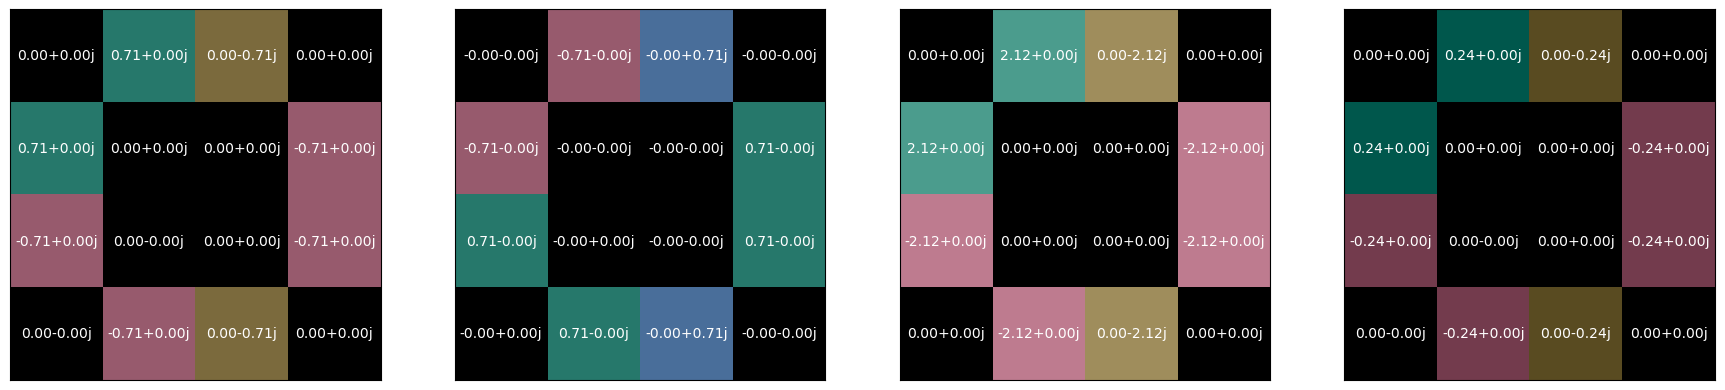

In [264]:
fig, ax = plt.subplots(1, 4, figsize=(22, 5))
for mat, ax in zip([S, -S, S * 3, S / 3], ax):
    complex_heatmap(mat, ax=ax)

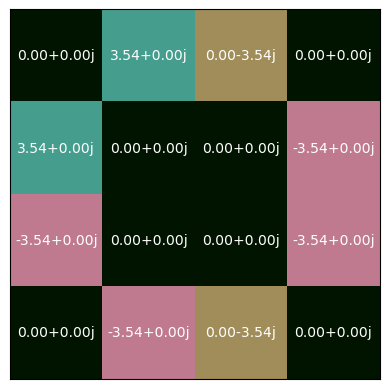

In [250]:
complex_heatmap(S * 5)

In [74]:
S @ S.conj().T

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [66]:
np.linalg.inv(S)

array([[ 0. +0.j ,  0.5+0.j , -0.5+0.j ,  0. +0.j ],
       [ 0.5+0.j ,  0. +0.j ,  0. +0.j , -0.5+0.j ],
       [ 0. +0.5j,  0. +0.j ,  0. +0.j ,  0. +0.5j],
       [ 0. -0.j , -0.5-0.j , -0.5-0.j ,  0. -0.j ]])

In [29]:
S @ so31.K2 - vector_rep(so31.K2) @ S

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [42]:
elts = [so31.J1, so31.K2, so31.K1]
rep = [vector_rep(e) for e in elts]
S_alt = solve_equivalence(elts, rep).round(4)[0]
S_alt /= S_alt.ravel()[np.abs(S_alt).argmax()]
S_alt

array([[ 0.-0.j,  1.+0.j,  0.-1.j,  0.+0.j],
       [ 1.+0.j, -0.+0.j,  0.+0.j, -1.+0.j],
       [-1.+0.j, -0.+0.j,  0.+0.j, -1.+0.j],
       [ 0.+0.j, -1.+0.j,  0.-1.j, -0.+0.j]])

In [43]:
spin1 = su2.alg_rep(3)

In [47]:
C = [spin1(su2.LieAlgElt(su2.S(i))) for i in range(1, 4)]

In [48]:
comm(C[0], C[1])

array([[0.-1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+1.j]])

In [49]:
C[2]

array([[0.-1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+1.j]])

In [50]:
C[0]

array([[0.+0.j , 0.-1.j , 0.+0.j ],
       [0.-0.5j, 0.+0.j , 0.-0.5j],
       [0.+0.j , 0.-1.j , 0.+0.j ]])

In [51]:
C[1]

array([[ 0. +0.j, -1. +0.j,  0. +0.j],
       [ 0.5+0.j,  0. +0.j, -0.5+0.j],
       [ 0. +0.j,  1. +0.j,  0. +0.j]])

In [52]:
C[2]

array([[0.-1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+1.j]])